In [46]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [47]:
dataset=MNIST(root='data/', download=False,transform=ToTensor())

In [48]:
img,label=dataset[0]
img.shape,label

(torch.Size([1, 28, 28]), 5)

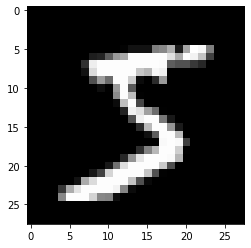

In [49]:
plt.imshow(img[0],cmap='gray')

In [50]:
def split_indices(n,val_pct):
    n_val=int(val_pct*n)
    idxs=np.random.permutation(n)
    return idxs[n_val:],idxs[:n_val]

In [51]:
train_indices,val_indices=split_indices(len(dataset),val_pct=0.2)
print(len(train_indices),len(val_indices))
print('Sample val indices: ',val_indices[:20])

48000 12000
Sample val indices:  [27181 12127 44131  2530 32028 49815  9979 17736 58481 56314  6301 45015
  3323 55882 14415 17459 42311 38334 27779 26973]


In [52]:
batch_size=100
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)
valid_sampler=SubsetRandomSampler(val_indices)
valid_dl=DataLoader(dataset,batch_size,sampler=valid_sampler)

In [53]:
class MnistModel(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        self.linear1=nn.Linear(in_size,hidden_size)
        self.linear2=nn.Linear(hidden_size, out_size)

    def forward(self,xb):
        xb=xb.view(xb.size(0),-1)
        out=self.linear1(xb)
        out=F.relu(out)
        out=self.linear2(out)
        return out

In [54]:
input_size=784
num_classes=10
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [55]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [57]:
for images,labels in train_dl:
    print('images.shape: ',images.shape)
    outputs=model(images)
    loss=F.cross_entropy(outputs,labels)
    print('Loss: ',loss.item())
    break
print('outputs.shape: ',outputs.shape)
print('Sample outputs: \n',outputs[:2].data)

images.shape:  torch.Size([100, 1, 28, 28])
Loss:  2.311738967895508
outputs.shape:  torch.Size([100, 10])
Sample outputs: 
 tensor([[0.0857, 0.1170, 0.0839, 0.1027, 0.0930, 0.0923, 0.1169, 0.1114, 0.1033,
         0.0938],
        [0.0962, 0.1198, 0.0903, 0.1002, 0.0891, 0.1005, 0.1021, 0.0958, 0.1019,
         0.1040]])


C:\Users\rrkot\AppData\Local\Temp\ipykernel_24432\681054329.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('Sample outputs: \n',F.softmax(outputs)[:2].data)


In [58]:
torch.cuda.is_available()

True

In [61]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        torch.device('cpu')


In [62]:
device=get_default_device()
device

device(type='cuda')

In [63]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return[to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

In [64]:
for images, labels in train_dl:
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break


torch.Size([100, 1, 28, 28])
cuda:0


In [66]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return(self.dl)

In [67]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [68]:
for xb,yb in valid_dl:
    print('xb.device: ',xb.device)
    print('yb', yb)
    break

xb.device:  cuda:0
yb tensor([9, 3, 5, 9, 1, 8, 7, 0, 9, 6, 0, 8, 6, 8, 9, 8, 0, 0, 5, 0, 7, 8, 5, 7,
        9, 4, 8, 7, 3, 0, 2, 7, 0, 7, 7, 3, 0, 3, 0, 5, 1, 8, 8, 5, 6, 0, 7, 8,
        2, 1, 3, 2, 3, 9, 4, 5, 6, 7, 6, 6, 7, 5, 1, 3, 7, 3, 0, 4, 7, 3, 6, 8,
        1, 3, 5, 2, 5, 4, 9, 3, 6, 7, 5, 8, 9, 1, 0, 0, 2, 3, 6, 4, 3, 9, 3, 7,
        7, 2, 4, 5], device='cuda:0')


In [69]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    preds=model(xb)
    loss=loss_func(preds,yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    metric_result=None
    if metric is not None:
        metric_result=metric(preds,yb)

    return loss.item(),len(xb),metric_result


In [92]:
def evaluate(model,loss_fn,valid_dl,metric=None):
    with torch.no_grad():
        results=[loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        losses,nums,metrics=zip(*results)
        total=np.sum(nums)
        avg_loss=np.sum(np.multiply(losses,nums))/total
        avg_metric=None
        if metric is not None:
            avg_metric=np.sum(np.multiply(metrics,nums))/total
    return avg_loss, total, avg_metric

In [93]:
def fit(epochs,lr,model,loss_fn,train_dl,valid_dl,metric=None,opt_fn=None):
    losses,metrics=[],[]

    if opt_fn is None:opt_fn=torch.optim.SGD
    opt=opt_fn(model.parameters(),lr=lr)

    for epoch in range(epochs):
        for xb,yb in train_dl:
            loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)

        result=evaluate(model,loss_fn,valid_dl,metric)
        val_loss,total,val_metric=result

        losses.append(val_loss)
        metrics.append(val_metric)

        if metric is None:
            print('Epoch[{}/{}], Loss: {:.4f}'.format(epoch+1,epochs,val_loss))
        else:
            print('Epoch[{}/{}, Loss: {:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
    return losses,metrics

In [94]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [95]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [96]:
val_loss,total,val_acc=evaluate(model,F.cross_entropy,valid_dl,metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss,val_acc))

Loss: 2.3062, Accuracy: 0.0858


In [98]:
losses1,metric1=fit(10,0.5,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/10, Loss: 0.1705
Epoch[2/10, Loss: 0.1473
Epoch[3/10, Loss: 0.1427
Epoch[4/10, Loss: 0.1452
Epoch[5/10, Loss: 0.1381
Epoch[6/10, Loss: 0.1354
Epoch[7/10, Loss: 0.1353
Epoch[8/10, Loss: 0.1467
Epoch[9/10, Loss: 0.1466
Epoch[10/10, Loss: 0.1567


Text(0.5, 1.0, 'Accuracy vs Epochs')

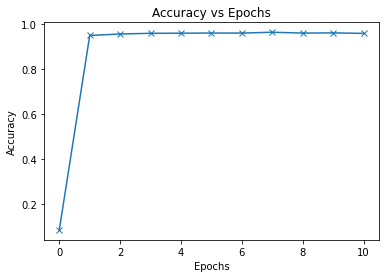

In [99]:
accuracies=[val_acc]+metric1
plt.plot(accuracies,'-x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')